## AR-моделирование

Для загрузки класса ar_model.AutoReg, который применяется для обучения одномерной авторегрессионной модели порядка p, используется пакет statsmodels.tsa.

Ниже приведены некоторые из ключевых шагов, которые необходимо выполнить для обучения AR-модели:

1. Отобразить временной ряд.
2. Проверить ряд на стационарность (модель AR можно применять только к стационарному временному ряду).
3. Выбрать параметр p (порядок модели AR).
4. Обучить модель.


Autoregression modelling fro [renewable energy generation in Germany between the years 2006–2017](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas). 


<span style="color: green">**Features:**</span>
* <code>Date</code> — дата (в формате гггг-мм-дд);
* ``Consumption`` — потребление электроэнергии (ГВтч);
* ``Wind`` — производство ветровой энергии (ГВтч);
* ``Solar`` — производство солнечной энергии (ГВтч);
* ``Wind+Solar`` — сумма производства ветровой и солнечной энергии (ГВтч).
В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_palette("husl")
# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

import tensorflow as tf
import joblib

#set path
import os
import sys
sys.path.insert(1, '../')
from utils.functions import Dickey_Fuller_test, plot_acf_pacf, optim_param, plot_history_regr, split_sequence, callbacks
from utils.models import  ModelLSTM,linear_model, get_predictions
 
from utils.config_reader import config_reader
# Import parameters
config = config_reader('../config/config.json')
random_state = config.random_seed
path_figures = config.path_figures
path_models = config.path_models

# fix random seed for reproducibility 
tf.random.set_seed(random_state)
# Hide model output
from IPython.display import clear_output

df = pd.read_csv("../data/energy_demand_OPSD.zip", sep=",",index_col="Date", parse_dates=['Date']) 
 
df.head(2)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN


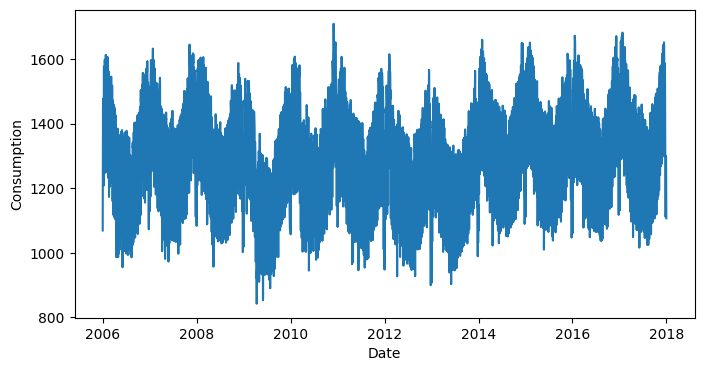

In [2]:
plt.figure(figsize=(8,4))
sns.lineplot(df, x=df.index, y='Consumption');

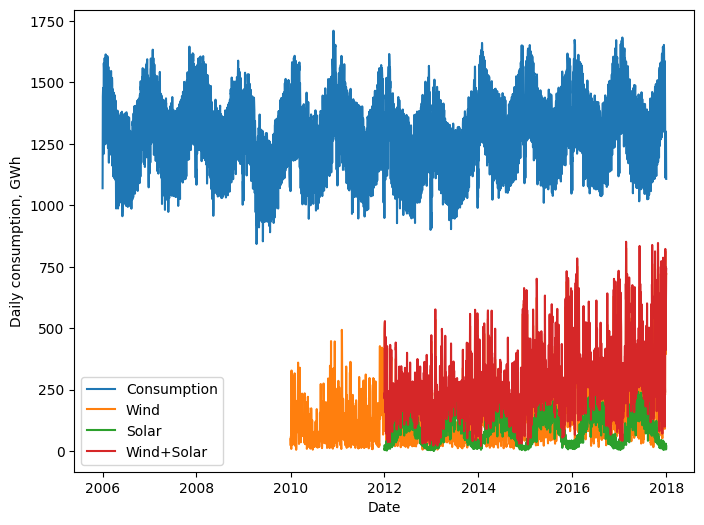

In [4]:
fig = plt.figure(figsize=(8,6))

for i,v in enumerate(df.columns):
    sns.lineplot(df, x=df.index, y=v, label=v)
plt.ylabel('Daily consumption, GWh');

> We may observe annual energy consumption in Germany. It is clear that the power demand has a remarkable seasonal component. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
 1   Wind         2920 non-null   float64
 2   Solar        2188 non-null   float64
 3   Wind+Solar   2187 non-null   float64
dtypes: float64(4)
memory usage: 171.2 KB


## Consumption change in time

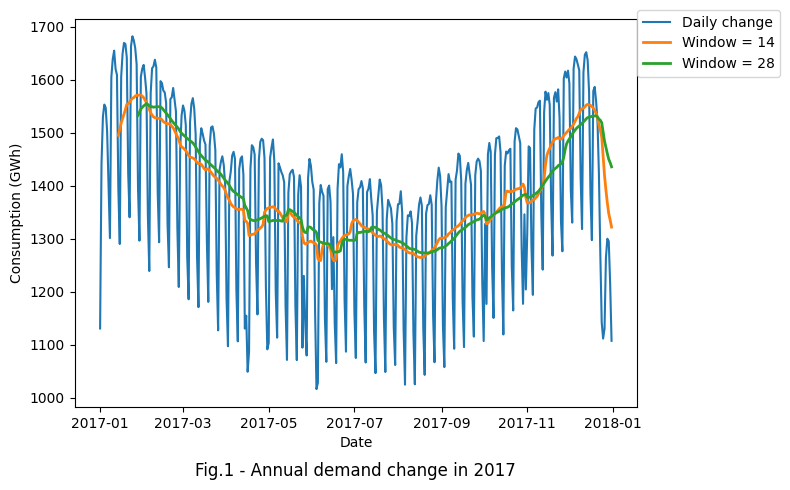

In [6]:
# calculate the weekly mean demand
#temp = df.loc['2017', 'Consumption'].reset_index().groupby(pd.Grouper(key='Date', freq='w'),as_index=False).mean().rename(columns={'Consumption':'Weekly_mean'})

fig_id = 1
plt.figure(figsize = (8,5))
#plt.subplots(figsize = (8,5))
sns.lineplot(df.loc['2017', 'Consumption'], label='Daily change');
#sns.lineplot(x=df.loc['2017', 'Consumption'].index[::7], y=temp['Weekly_mean'].values, c='r', label='Weekly_mean')

window = np.linspace(14,28,2).astype("int8") # Set 2 window sizes: 14,28
#markers = ['o', 'x']

for i in range(window.shape[0]):
    plt.plot(
        df.loc['2017', 'Consumption'].rolling(window=window[i]).mean(),
        label="Window = {}".format(window[i]),
        linewidth=2, 
    )
    
plt.legend(loc=(1,0.85))
plt.ylabel('Consumption (GWh)')
plt.title("Fig.{} - Annual demand change in 2017".format(fig_id), y=-0.2);
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

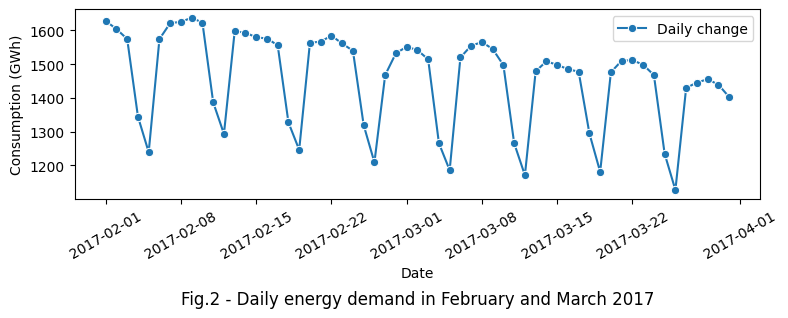

In [ ]:
fig_id = 2
plt.figure(figsize = (8,4))
sns.lineplot(df.loc['2017-02':'2017-03', 'Consumption'], label='Daily change', marker='o');

#plt.legend(loc=(1,0.85))
plt.ylabel('Consumption (GWh)')
plt.xticks(rotation=30)
plt.title("Fig.{} - Daily energy demand in February and March 2017".format(fig_id), y=-0.6)
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

## Seasonality

In [8]:
df['month'] = df.index.month
df['weekday'] = df.index.day_name()
df[['month','weekday']].head()

,month,weekday
Date,,
2006-01-01,1,Sunday
2006-01-02,1,Monday
2006-01-03,1,Tuesday
2006-01-04,1,Wednesday
2006-01-05,1,Thursday


In [ ]:
df.head(1)

,Consumption,Wind,Solar,Wind+Solar,month,weekday
Date,,,,,,
2006-01-01,1069.184,NaN,NaN,NaN,1,Sunday


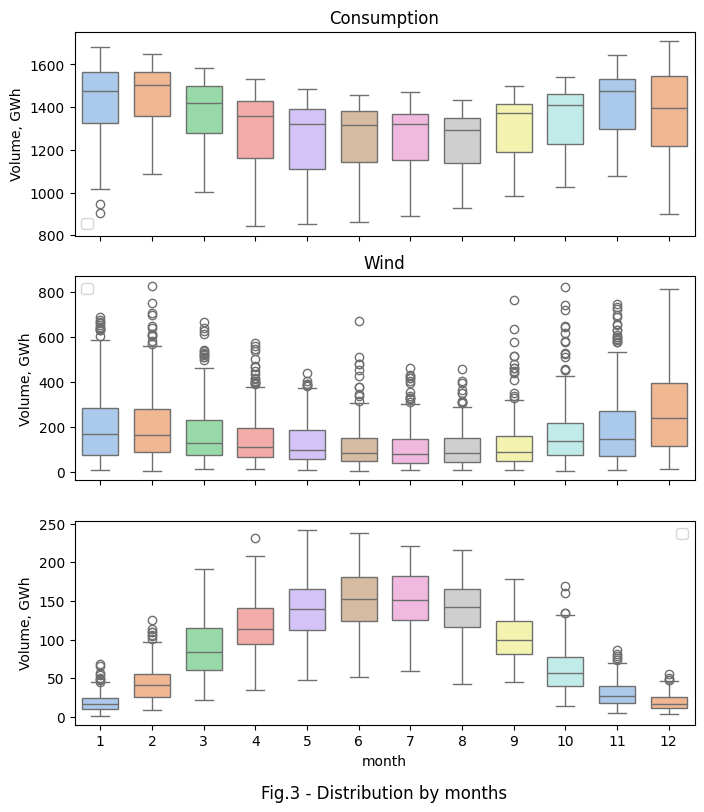

In [9]:
fig, ax = plt.subplots(3,1, figsize=(8,9), sharex=True)

for i,name in enumerate(df.columns[:3]):
    sns.boxplot(data=df, x='month', y=name, width=0.7, ax=ax[i], hue='month', palette="pastel") #palette="husl"
    ax[i].set_title(name)
    ax[i].set_ylabel('Volume, GWh')
    ax[i].legend('');
    
fig_id = 3
plt.title(f'Fig.{fig_id} - Distribution by months', y=-0.4);

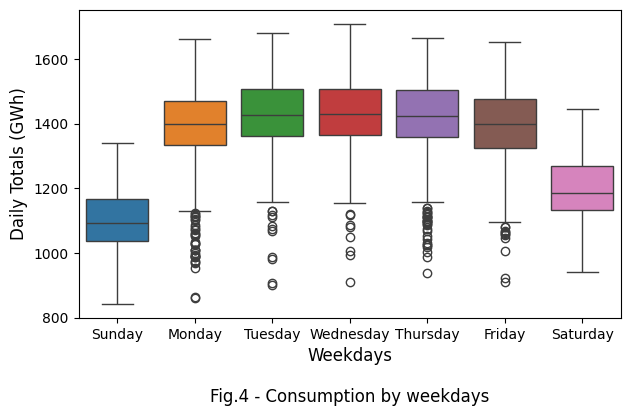

In [ ]:
plt.subplots(figsize=(7,4))
sns.boxplot(df, x='weekday', y='Consumption', hue='weekday') #, c=i , palette="husl"
plt.ylabel('Daily Totals (GWh)', fontsize=12)
plt.xlabel('Weekdays', fontsize=12)

fig_id = 4
plt.title(f'Fig.{fig_id} - Consumption by weekdays', y=-0.3);

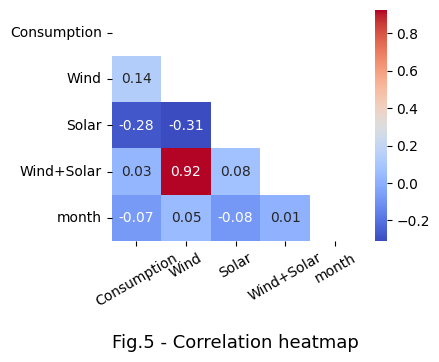

In [ ]:
fig = plt.figure(figsize=(4, 3))
 
matrix = np.triu(df.corr(numeric_only=True))  
fig = sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.02f', cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0
plt.xticks(rotation=30)

fig_id = 5
plt.title(f'Fig.{fig_id} - Correlation heatmap', y=-0.5, fontsize=13);

In [10]:
df.drop(['Wind+Solar'],axis=1, inplace=True) # delete the feature with high correlation
df.isna().sum()

Consumption       0
Wind           1463
Solar          2195
month             0
weekday           0
dtype: int64

In [ ]:
# fig = plt.figure(figsize=(10,4))
# sns.scatterplot(df.iloc[3000:])
# fig_id = 5
# plt.title(f'Fig.{fig_id} - Features by time', y=-0.5, fontsize=13);

# Modelling

## LSTM

In [12]:
# Selection
X = df[['Consumption']]

# Scaling
standardScaler = StandardScaler()

X_scaled = standardScaler.fit_transform(X)
# save scaler
joblib.dump(standardScaler, os.path.join(config.path_models, 'scaler.gz'))

X_scaled[:3]

array([[-1.62582675],
       [ 0.25244916],
       [ 0.62656353]])

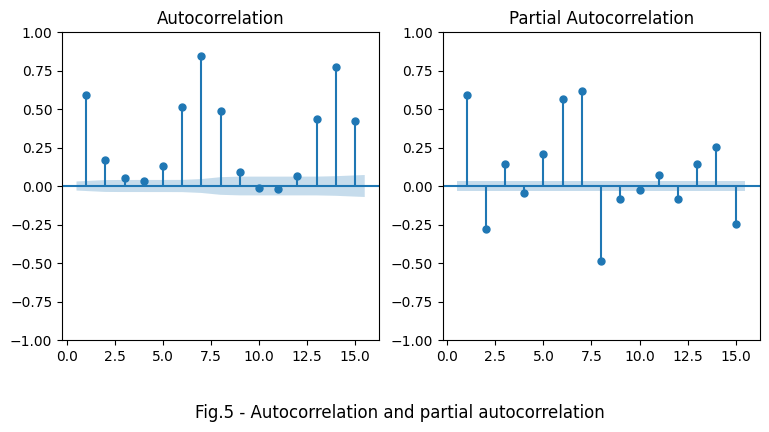

In [13]:
# check lags
plot_acf_pacf(X_scaled, lags=15, fig_id=5) #df['Consumption']

In [14]:
# choose a number of time steps (every 7 days)
n_steps = config.n_steps
# split into samples
 
X_splitted, y_splitted = split_sequence(X_scaled, n_steps=n_steps) 
#print(X_splitted.shape,  y_splitted.shape)

X_train, X_test = X_splitted[:len(X)-100], X_splitted[len(X)-100:] 
y_train, y_test = y_splitted[:len(X)-100], y_splitted[len(X)-100:]
print('X_train', X_train.shape,'\ny_train', y_train.shape)

X_train (4283, 7, 1) 
y_train (4283, 1)


In [15]:
model = ModelLSTM(X_train).build_model()

input_shape = (7, 1) | output_units = KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 7, 256)            264192    
                                                                 
 lstm_1 (LSTM)               (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 301,217
Trainable params: 301,217
Non-trainable params: 0
_________________________________________________________________


### training

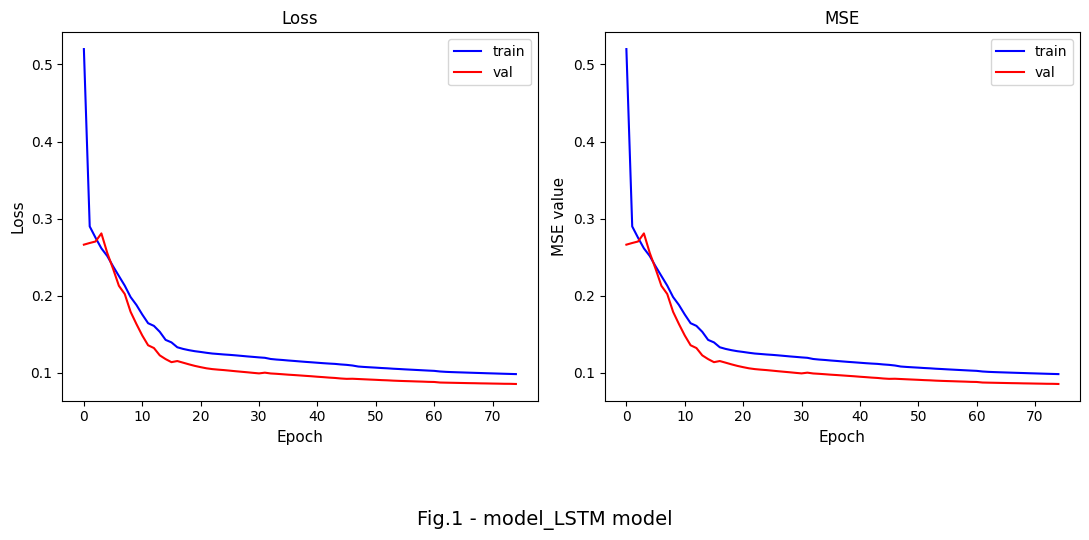

In [ ]:
# # fit model
# history = model.fit(
#     X_train, 
#     y_train, 
#     validation_split=0.1,
#     shuffle=False,
#     epochs=75, 
#     verbose=True,
#     callbacks= callbacks(      
#         lr=config.model.learning_rate, model_name=model.name
#     )
# )

# model.save(os.path.join(config.path_models, model.name + '.hdf5')) # full model

# #model.save_weights(os.path.join(path_models, 'weights'+'.h5')) # only weights

# clear_output(wait=False)

# plot_history_regr(history=history, model_name=model.name)

## Prediction

In [16]:
# Loanding saved model
model1 = tf.keras.models.load_model(os.path.join(path_models, 'model_LSTM.hdf5'))#'LSTM_model.hdf5'

y_pred = model1.predict(X_test)#.squeeze()
#print('y_pred', y_pred.shape,'\ny_test', y_test.shape)

scaler = joblib.load(os.path.join(config.path_models, 'scaler.gz'))

y_pred_inverse = pd.Series(standardScaler.inverse_transform(y_pred)[:,0], name='y_pred', index=X.index[-y_test.shape[0]:]) 
y_test_inverse = pd.Series(standardScaler.inverse_transform(y_test).squeeze(), name='y_test', index=X.index[-y_test.shape[0]:]) 

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred_inverse, y_test_inverse)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred_inverse, y_test_inverse)))

3/3 [==============================] - 0s 7ms/step
MSE score:  4220.548
MAPE score: 0.028


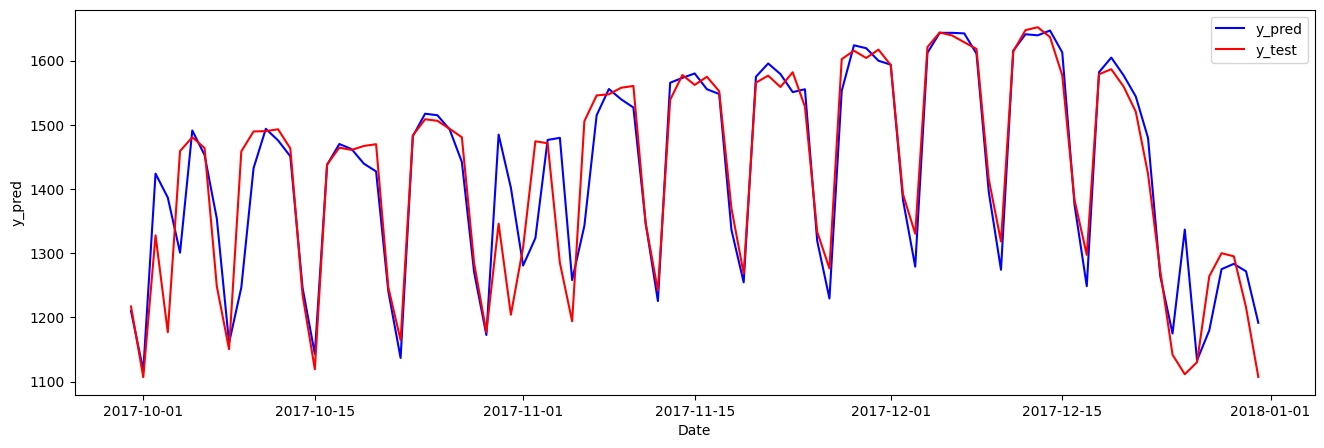

In [17]:
indexes = X.index[-y_test_inverse.shape[0]:]
length = X_test.shape[0]

plt.figure(figsize=(16,5))
sns.lineplot(y_pred_inverse, c='b', label='y_pred')
sns.lineplot(y_test_inverse, c='r', label='y_test');

# The next period

In [18]:
predictions = get_predictions(
    periods_to_forecast=8, 
    last_prediction=X_test[-1,:], 
    last_index=X.index[-1], 
    scaler=joblib.load(os.path.join(config.path_models, 'scaler.gz')),
    model=model1
    )

predictions

2017-12-31    1191.500366
2018-01-01    1222.643188
2018-01-02    1260.762207
2018-01-03    1335.041626
2018-01-04    1358.360474
2018-01-05    1360.233887
2018-01-06    1352.209473
2018-01-07    1358.675415
Name: future, dtype: float32

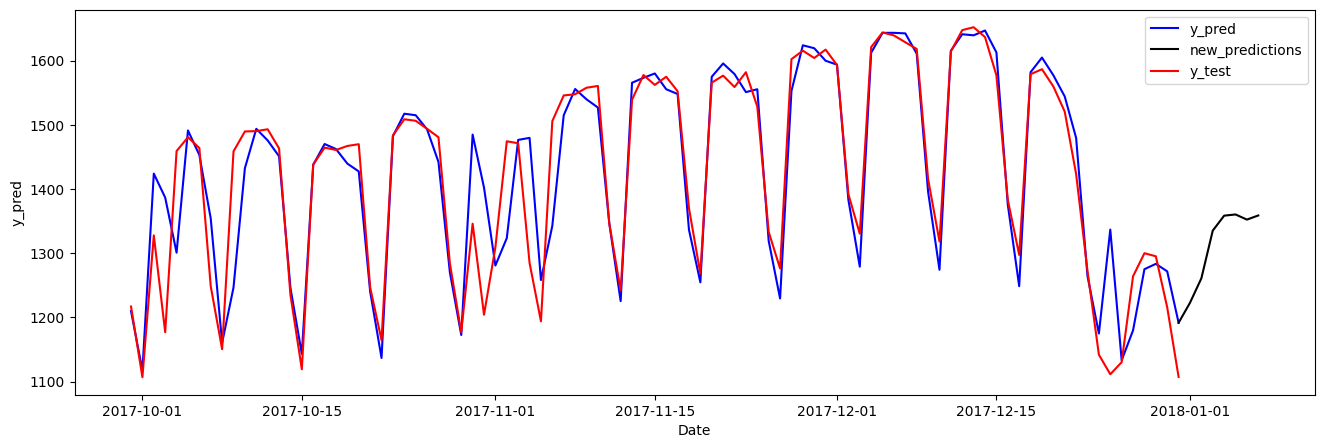

In [19]:
indexes = X.index[-y_test_inverse.shape[0]:]
length = X_test.shape[0]

plt.figure(figsize=(16,5))
sns.lineplot(y_pred_inverse, c='b', label='y_pred')
sns.lineplot(predictions, c='k', label='new_predictions')
sns.lineplot(y_test_inverse, c='r', label='y_test');

## TF linear

In [ ]:
# # shift the target variable
# y_scaled = np.roll(X_scaled, shift=-1)

# X_train, X_test = X_scaled[:len(X)-100], X_scaled[len(X)-100:] 
# y_train, y_test = y_scaled[:len(X)-100], y_scaled[len(X)-100:] 

In [20]:
model2 = linear_model(X_train).build_model()

input_shape = (7, 1) | output_units = KerasTensor(type_spec=TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")
Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 dense_1 (Dense)             (None, 7, 256)            512       
                                                                 
 dense_2 (Dense)             (None, 7, 32)             8224      
                                                                 
 dense_3 (Dense)             (None, 7, 1)              33        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_____________________________________________________________

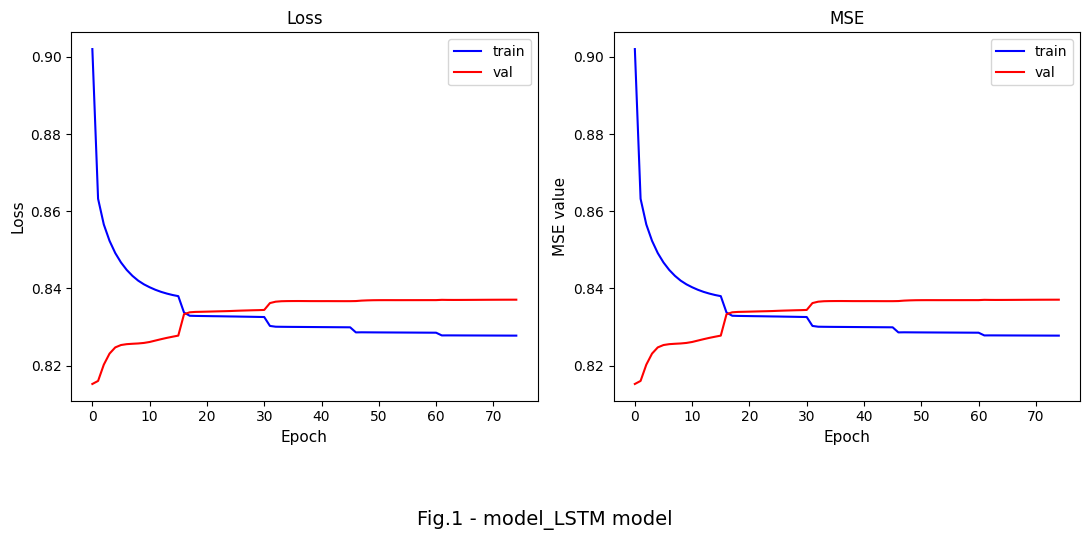

In [21]:
# fit model
history2 = model2.fit(
    X_train, 
    y_train, 
    validation_split=0.1,
    shuffle=False,
    epochs=75, 
    verbose=True,
    callbacks= callbacks(      
        lr=config.model.learning_rate, model_name=model2.name
    )
)

model2.save(os.path.join(config.path_models, model2.name + '.hdf5')) # full model

#model.save_weights(os.path.join(path_models, 'weights'+'.h5')) # only weights

clear_output(wait=False)

plot_history_regr(history=history2, model_name=model.name)

In [47]:
# Loanding saved model
model22 = tf.keras.models.load_model(os.path.join(path_models, 'linear_model.hdf5'))#'LSTM_model.hdf5'

y_pred = model22.predict(X_test)#.squeeze()
#print('y_pred', y_pred.shape,'\ny_test', y_test.shape)

scaler = joblib.load(os.path.join(config.path_models, 'scaler.gz'))

y_pred_linear = pd.Series(standardScaler.inverse_transform(y_pred.squeeze())[:,0], name='y_pred', index=X.index[-y_test.shape[0]:]) 
y_test_inverse = pd.Series(standardScaler.inverse_transform(y_test).squeeze(), name='y_test', index=X.index[-y_test.shape[0]:]) 

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred_linear, y_test_inverse)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred_linear, y_test_inverse)))

3/3 [==============================] - 0s 2ms/step
MSE score:  16534.540
MAPE score: 0.080


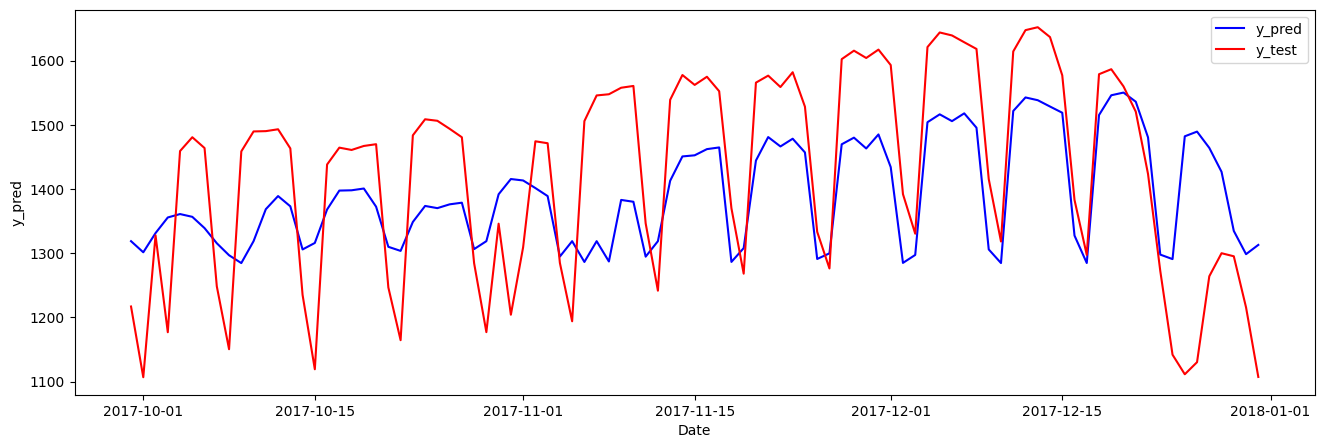

In [48]:
indexes = X.index[-y_test_inverse.shape[0]:]
length = X_test.shape[0]

plt.figure(figsize=(16,5))
sns.lineplot(y_pred_linear, c='b', label='y_pred')
#sns.lineplot(predictions, c='k', label='new_predictions')
sns.lineplot(y_test_inverse, c='r', label='y_test');

# Other

> Let us split the dataset into samples  sequentially.

In [ ]:
df = df.iloc[:,:-2]
train_data = df[:len(df)-100] #['Consumption']
test_data = df[len(df)-100:] #['Consumption']
train_data.head()

,Consumption,Wind,Solar
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN
2006-01-04,1457.217,NaN,NaN
2006-01-05,1477.131,NaN,NaN


<Figure size 600x300 with 0 Axes>

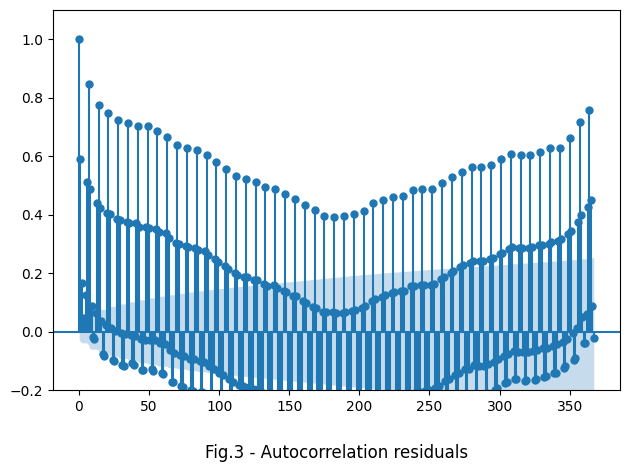

In [ ]:
fig_id = 3
fig = plt.figure(figsize=(6,3))
plot_acf(train_data['Consumption'], lags=367)

plt.title("Fig.{} - Autocorrelation residuals".format(fig_id), y=-0.2)
plt.ylim([-0.2, 1.1])
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

> Let us define the number of lags. As it can be seen, that high autocorrelation might be observed every 8 periods which menas lags=8 (AR(8))
>
> Fianlly, let us try to train the autoregression model.

## Autoregression model

In [ ]:
ar_model = AutoReg(X['Consumption'], lags=365).fit()
#print(ar_model.summary())

> Let us predict the test data. To do this, we need to define following arguments in the ``predict`` method: the beginning  and ending periods. In our case it will be ``len(train_data)``, which is equivalent ``len(df)-100`` because ``len(df) = len(train_data) + len(test_data)``.

In [55]:
train_data, test_data = X[:len(X)-100], X[len(X)-100:] 

print('train_data', train_data.shape,'\ntest_data', test_data.shape)

train_data (4283, 1) 
test_data (100, 1)


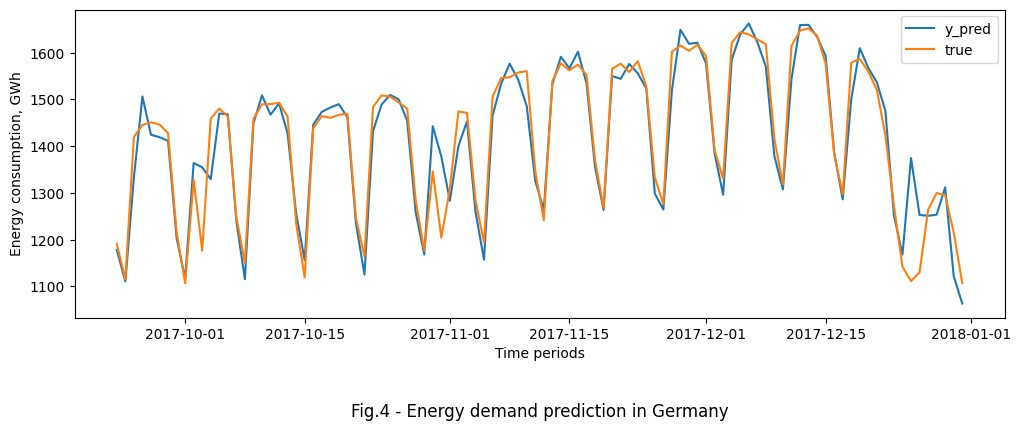

In [56]:
# make a prediction
pred = ar_model.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

fig_id = 4
plt.figure(figsize=(12,4))
sns.lineplot(data=pred, label='y_pred')
sns.lineplot(data=test_data['Consumption'], label='true')
plt.xlabel('Time periods')
plt.ylabel('Energy consumption, GWh')
plt.title('Fig.{} - Energy demand prediction in Germany'.format(fig_id), y=-0.35);

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

In [57]:
d=14
temp = df.loc[pred.index[0]-pd.DateOffset(days=d):,'Consumption'].rolling(window=d).mean().dropna().to_frame() #pd.DataFrame(, columns=['y'])
temp['ci_low'] = temp['Consumption'] - 4*temp['Consumption'].std()
temp['ci_high'] = temp['Consumption'] + 2.5*temp['Consumption'].std()

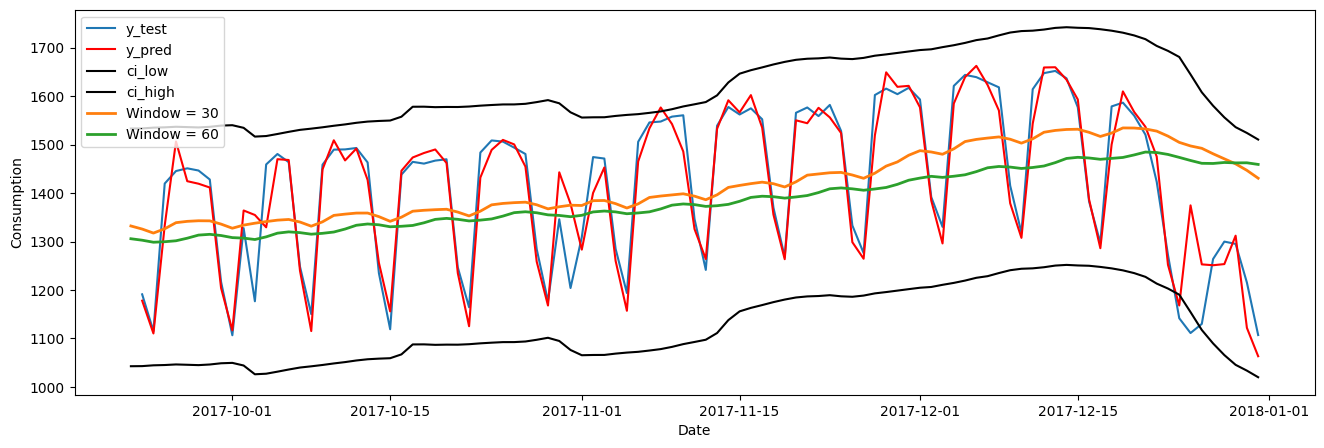

In [58]:
#df_2017 = df.loc[pred.index[0]:,:] # restrict the
plt.figure(figsize=(16,5))
sns.lineplot(test_data, x=test_data.index, y='Consumption', label='y_test')
sns.lineplot(x=pred.index, y=pred, c='r', label='y_pred');
sns.lineplot(x=temp.index, y=temp['ci_low'], c='k', label='ci_low');
sns.lineplot(x=temp.index, y=temp['ci_high'], c='k', label='ci_high');

window = [30,60]
for i,d in enumerate(window):
    plt.plot(
        df.loc[pred.index[0]-pd.DateOffset(days=d):,'Consumption'].rolling(window=d).mean(),
        label="Window = {}".format(window[i]),#
        linewidth=2, 
    )
plt.legend();

In [59]:
from sklearn.metrics  import  mean_squared_error, mean_absolute_percentage_error

print('MSE score:  {:.3f}'.format(mean_squared_error(test_data['Consumption'], pred)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(test_data['Consumption'], pred)))

MSE score:  2681.974
MAPE score: 0.024


<Axes: xlabel='day_of_year', ylabel='Consumption'>

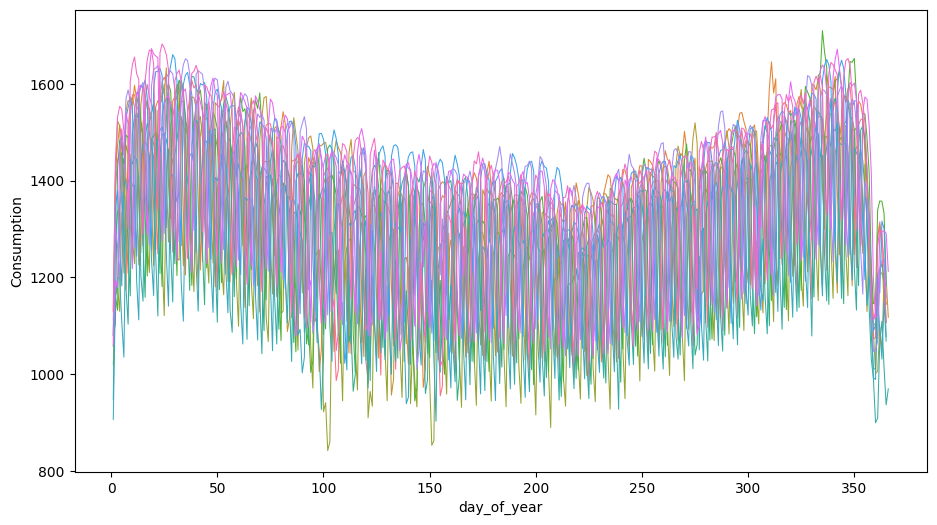

In [ ]:
# def seasonal_plot(X, y, period, freq, ax=None):
#     if ax is None:
#         _, ax = plt.subplots()
#     palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
#     ax = sns.lineplot(
#         x=freq,
#         y=y,
#         hue=period,
#         data=X,
#         ci=False,
#         ax=ax,
#         palette=palette,
#         legend=False,
#     )
#     ax.set_title(f"Seasonal Plot ({period}/{freq})")
#     for line, name in zip(ax.lines, X[period].unique()):
#         y_ = line.get_ydata()[-1]
#         ax.annotate(
#             name,
#             xy=(1, y_),
#             xytext=(6, 0),
#             color=line.get_color(),
#             xycoords=ax.get_yaxis_transform(),
#             textcoords="offset points",
#             size=14,
#             va="center",
#         )
#     return ax

# # X = tunnel.copy()

# # # days within a week

# df['year'] = df['Consumption'].index.year # year
# df['day_of_year'] = df['Consumption'].index.day_of_year  # days within a year
# fig = plt.figure(figsize=(11, 6))
# #seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
# #seasonal_plot(df, y="Consumption", period='year', freq="dayofyear");

# palette = sns.color_palette("husl", n_colors=df['year'].nunique(),)
# # sns.scatterplot(
# #     data=df, x='day_of_year', y="Consumption", hue="year", legend=False, palette=palette, size=5,
# #     )

# sns.lineplot(
#     data=df, x='day_of_year', y="Consumption", hue="year", legend=False, 
#     palette=palette, size=5);

<Figure size 1200x1400 with 0 Axes>

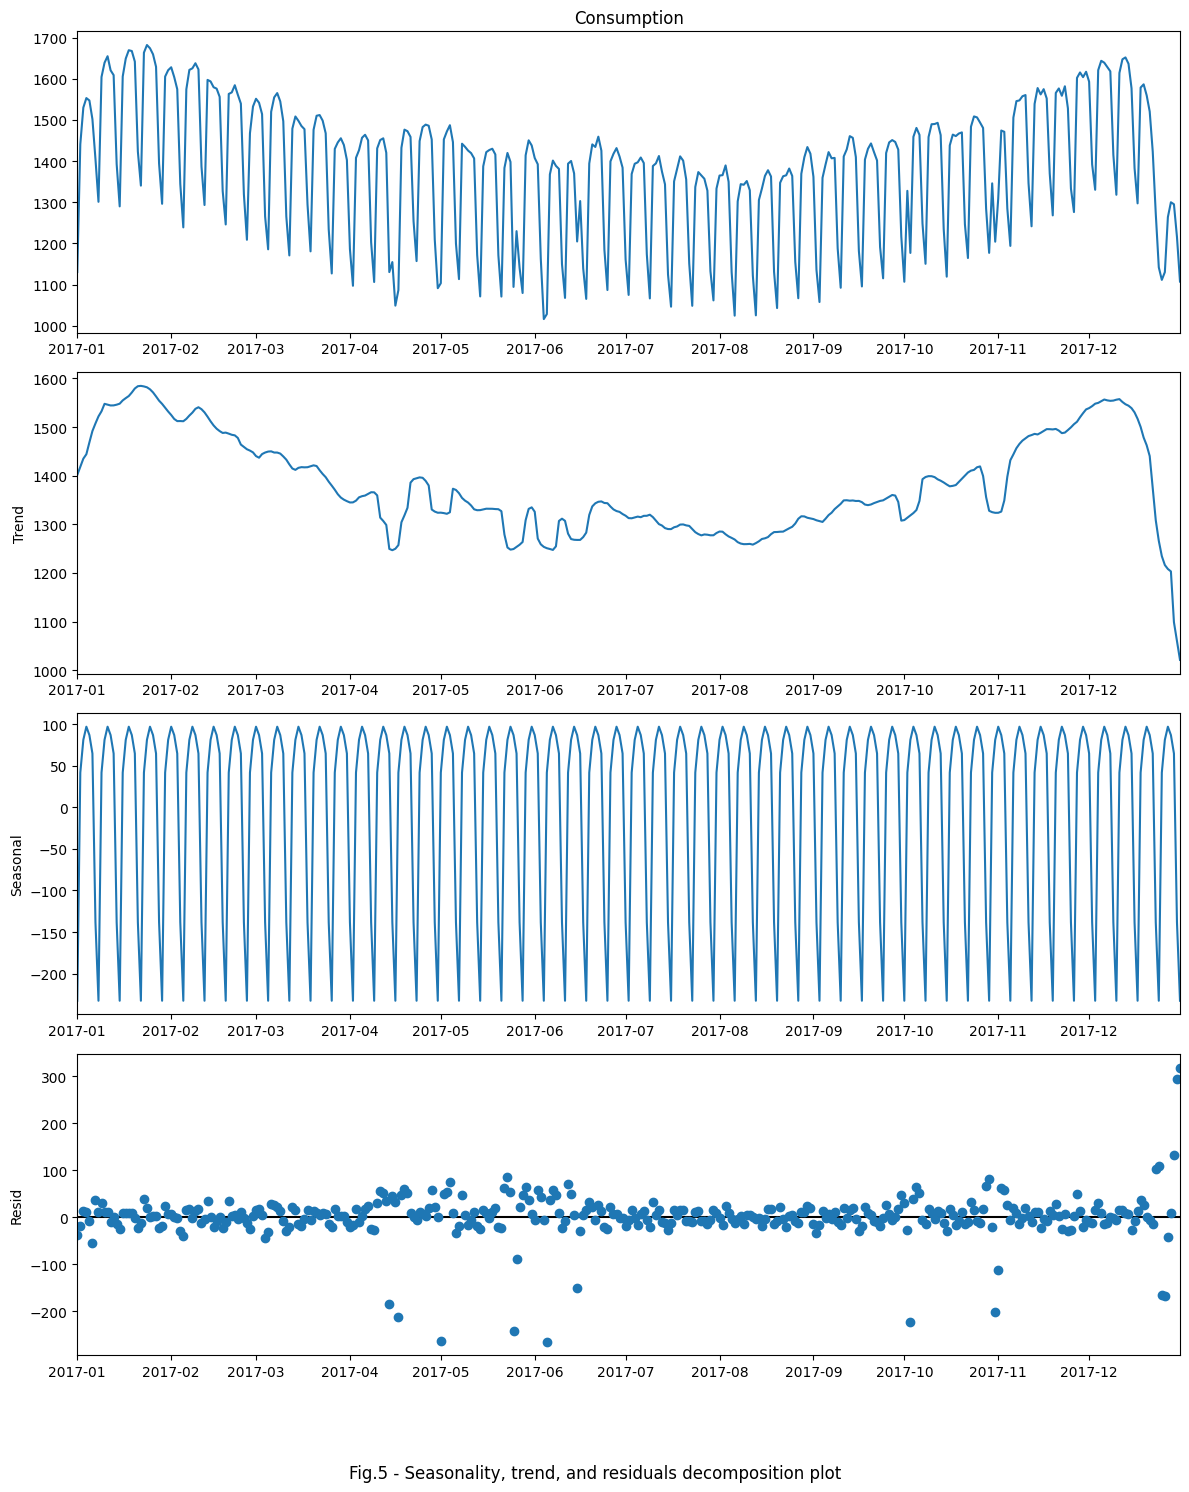

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12,14))
# Decomposition
decomposition = seasonal_decompose(df[df.index.year==2017]['Consumption'],  extrapolate_trend='freq').plot() #

fig_id = 5
plt.suptitle("Fig.{} - Seasonality, trend, and residuals decomposition plot".format(fig_id), y=-0.05)
plt.show();
#decomposition.plot();

In [ ]:
train_diff, diff_order = Dickey_Fuller_test(train_data['Consumption'])

ADF Statistic: -6.12
p-value: 9e-08
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary series
Diff order = 0


C:\Users\Lena\AppData\Local\Temp\ipykernel_7904\3253696076.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


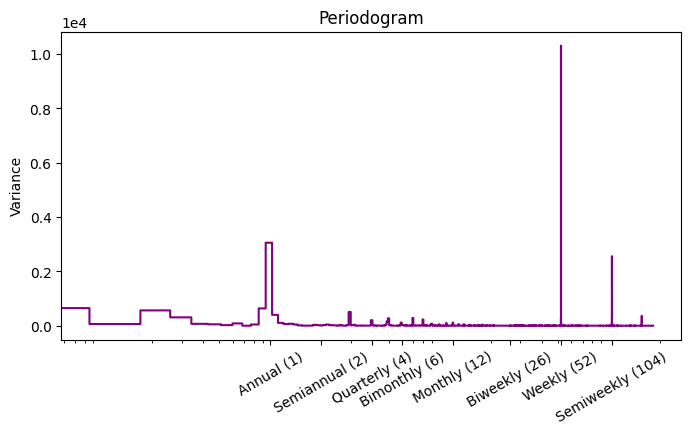

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(8,4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(train_data['Consumption']);

## ARIMA model

In [ ]:
p = 14 # last significant lag taken from the partial autocorrelation graph
d = 1 # difference order
q = 7 # last significant lag taken from the  autocorrelation graph
arima_model = ARIMA(train_data['Consumption'], order=(p, d, q))
arima_model_fit = arima_model.fit()
#arima_model_fit.summary()

In [ ]:
result = optim_param(data=train_data['Consumption'], field=np.arange(6,8))
result.head()

In [ ]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_data['Consumption'], # unchanged dataset!!!
    start_p=7, max_p=14, start_P=0,
    d=1, D=1, m=1,
    start_q=25, max_q=28, 
    test="adf",
    error_action="ignore",
    trace=True,seasonal=False
)

smodel.summary()

Performing stepwise search to minimize aic


In [ ]:
# substitute optimal parameters (mine seems to me better)
arima_model = ARIMA(train_data['Consumption'], order=(14, 1, 7))
arima_model = arima_model.fit()
arima_pred = arima_model.predict(start=test_data.index[0], end=test_data.index[-1])
arima_pred

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\s

2017-09-23    1201.277875
2017-09-24    1118.638065
2017-09-25    1397.678660
2017-09-26    1426.073277
                 ...     
2017-12-28    1438.387859
2017-12-29    1385.872776
2017-12-30    1216.854201
2017-12-31    1162.138546
Freq: D, Name: predicted_mean, Length: 100, dtype: float64

In [ ]:
# forecast = arima_model.conf_int(alpha=0.05)
forecast_df = arima_model.get_forecast(len(test_data.index))
forecast_df = forecast_df.conf_int(alpha=0.05) # Confidence level of 95%
forecast_df.head(2)

,lower Consumption,upper Consumption
2017-09-23,1081.164158,1321.391592
2017-09-24,973.003806,1264.272325


In [ ]:
prediction_arima = pd.DataFrame({
    'y': test_data['Consumption'].values.ravel(),
    'y_hat': arima_pred.values,
    'ci_lower': forecast_df.iloc[:,0],
    'ci_upper': forecast_df.iloc[:,1]}) # test.reset_index()['year']
#prediction_arima = prediction_arima.set_index(idx)

#prediction_arima.reset_index()
prediction_arima['time'] = test_data.index #np.arange(2019,2022).astype('int16')
prediction_arima = prediction_arima.set_index('time')
prediction_arima.head(2)

,y,y_hat,ci_lower,ci_upper
time,,,,
2017-09-23,1191.10345,1201.277875,1081.164158,1321.391592
2017-09-24,1115.07288,1118.638065,973.003806,1264.272325


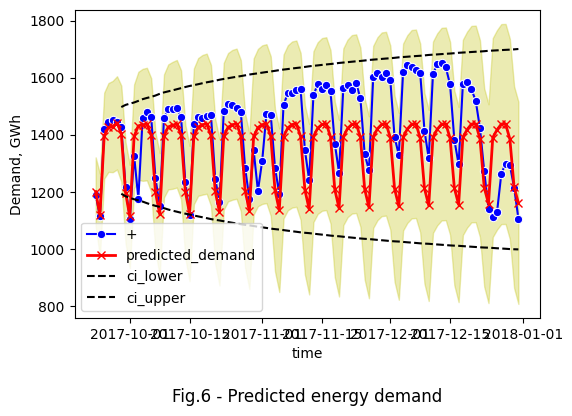

In [ ]:
fig_id = 6
import matplotlib.ticker as ticker
x = np.arange(2019,2022).astype('int16') #list(pd.to_datetime(prediction_arima.index).year.values)

plt.figure(figsize=(6,4))
fig = sns.lineplot(prediction_arima['y'], c='b', label='+', marker='o') #  lw=1
plt.plot(prediction_arima['y_hat'], 'x-r', label='predicted_demand', lw=2)
plt.plot(prediction_arima[['ci_lower','ci_upper']].rolling(window=7).mean(),'--k',label=['ci_lower','ci_upper'])
plt.fill_between(prediction_arima.index, prediction_arima['ci_lower'].values, prediction_arima['ci_upper'].values, color='y', alpha=0.3)

#plt.xticks(np.arange(2019,2022))

#scale_factor_y = 1e9
#ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
#fig.yaxis.set_major_formatter(ticks_y)#
plt.ylabel("GDP, billions usd")

plt.legend()
plt.title("Fig.{} - Predicted energy demand".format(fig_id), y=-0.3)
plt.ylabel("Demand, GWh")
plt.show();

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_scaled_poly, y_train)
y_pred = model.predict(X_test_scaled_poly)

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred, y_test)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred, y_test)))

MSE score:  17802.401
MAPE score: 0.076


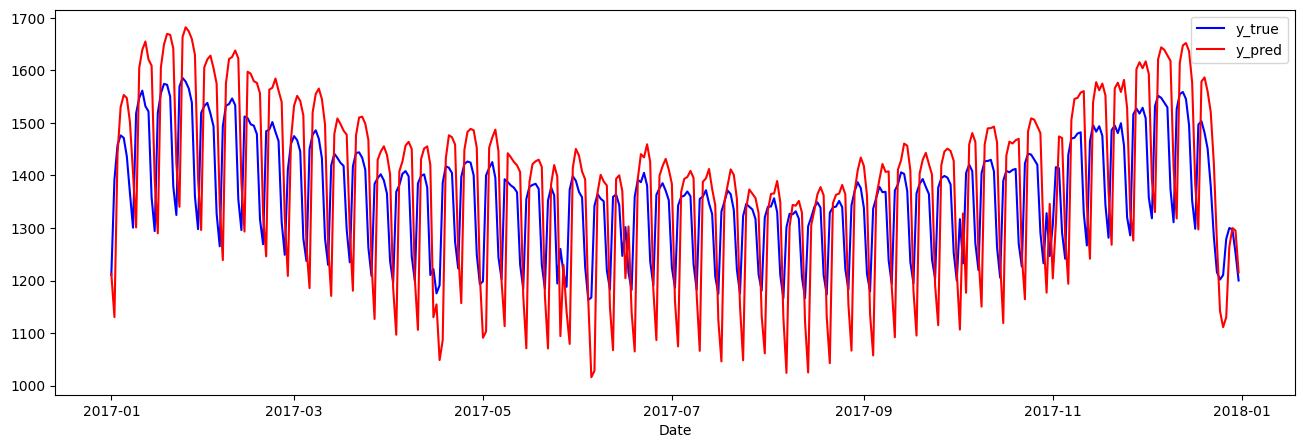

In [ ]:
period = '2017-01-01'
length = X_test.loc[period:,:].shape[0]

plt.figure(figsize=(16,5))
#sns.lineplot(test_data, x=test_data.index, y='Consumption', label='y_test')
sns.lineplot(x=X_test.loc[period:,:].index, y=y_pred.reshape(-1,)[-length:], c='b', label='y_true');
sns.lineplot(x=X_test.loc[period:,:].index, y=y_test.reshape(-1,)[-length:], c='r', label='y_pred');
 